In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import re
from datetime import datetime

In [33]:
# Charger les données
train = pd.read_csv("airbnb_train.csv")
test = pd.read_csv("airbnb_test.csv")

print("Shape train:", train.shape)
print("Shape test :", test.shape)

train.head()
test.to_excel("airbnb_test.xlsx", index=False)

Shape train: (22234, 28)
Shape test : (51877, 27)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

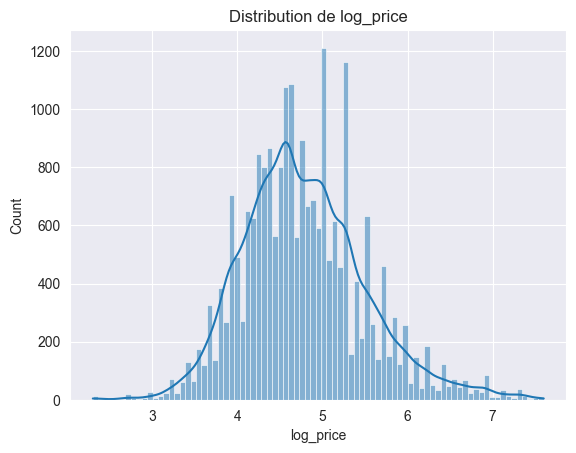

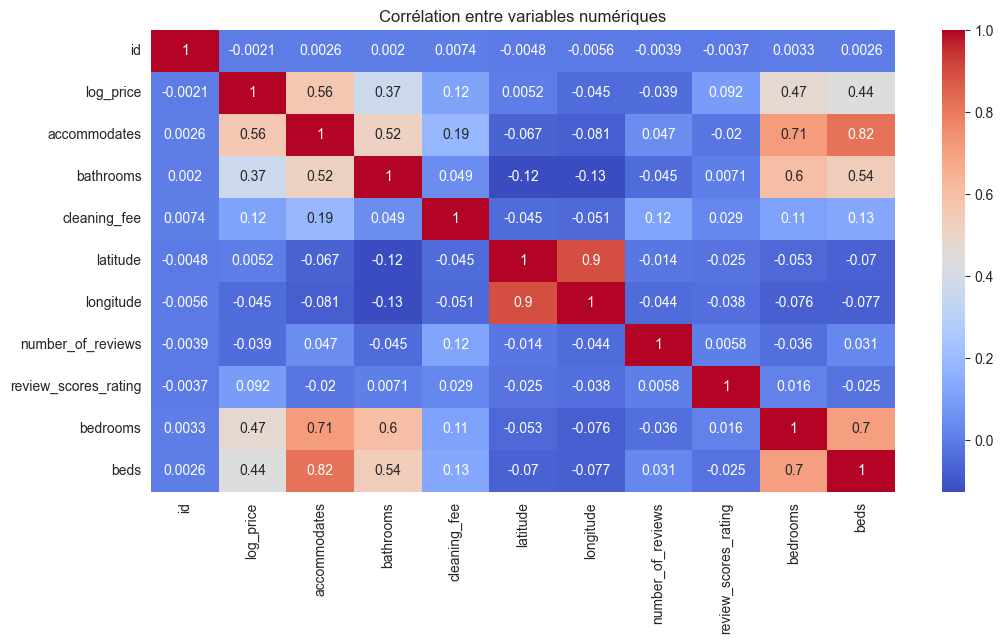


property_type - top valeurs :
property_type
Apartment      14635
House           4965
Condominium      836
Townhouse        507
Loft             381
Name: count, dtype: int64

room_type - top valeurs :
room_type
Entire home/apt    12348
Private room        9219
Shared room          667
Name: count, dtype: int64

bed_type - top valeurs :
bed_type
Real Bed         21622
Futon              222
Pull-out Sofa      162
Airbed             146
Couch               82
Name: count, dtype: int64

cancellation_policy - top valeurs :
cancellation_policy
strict             9726
flexible           6754
moderate           5712
super_strict_30      37
super_strict_60       5
Name: count, dtype: int64

city - top valeurs :
city
NYC        9739
LA         6672
SF         1924
DC         1744
Chicago    1127
Name: count, dtype: int64


In [29]:
# Aperçu des types et valeurs manquantes
train.info()
train.isnull().mean().sort_values(ascending=False).head(15)

# Distribution de la cible
sns.histplot(train['log_price'], kde=True)
plt.title("Distribution de log_price")
plt.show()

# Corrélation numériques
plt.figure(figsize=(12, 6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Corrélation entre variables numériques")
plt.show()

# Catégories principales
for col in ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']:
    print(f"\n{col} - top valeurs :")
    print(train[col].value_counts().head(5))


In [30]:
# Fonction pour traiter les datasets
def preprocess(df):
    df = df.copy()

    # Imputation simple
    df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
    df['bedrooms'] = df['bedrooms'].fillna(1)
    df['beds'] = df['beds'].fillna(1)
    df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())

    # Dates
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['host_duration'] = (pd.to_datetime('2020-01-01') - df['host_since']).dt.days
    df['review_recency'] = (pd.to_datetime('2020-01-01') - df['last_review']).dt.days

    # Booléens
    for col in ['instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'cleaning_fee']:
        df[col] = df[col].map({'t': 1, 'f': 0, True: 1, False: 0}).fillna(0)

    # Longueur des textes
    df['desc_length'] = df['description'].fillna('').apply(len)
    df['name_length'] = df['name'].fillna('').apply(len)

    # Amenités : nombre d'amenities
    df['n_amenities'] = df['amenities'].apply(lambda x: len(re.findall(r'\"', str(x))) // 2)

    return df

train_processed = preprocess(train)
test_processed = preprocess(test)

features_to_use = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'instant_bookable', 'host_identity_verified', 'host_has_profile_pic',
    'cleaning_fee', 'review_scores_rating', 'number_of_reviews',
    'host_duration', 'review_recency', 'desc_length', 'name_length',
    'n_amenities', 'latitude', 'longitude',
    'property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city'
]

target = 'log_price'


In [31]:
# Séparation X / y
X = train_processed[features_to_use]
y = train_processed[target]
X_test_final = test_processed[features_to_use]

# Définir colonnes catégorielles
cat_cols = ['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city']
num_cols = [col for col in features_to_use if col not in cat_cols]

# Pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

model = Pipeline([
    ('prep', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split local
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
model.fit(X_train, y_train)

# Prédiction locale
y_pred = model.predict(X_val)
from math import sqrt
rmse = sqrt(mean_squared_error(y_val, y_pred))

print(f"Validation RMSE: {rmse:.4f}")


Validation RMSE: 0.4134


In [32]:
# Recharger juste pour l'id si besoin
test_ids = pd.read_csv("airbnb_test.csv")['id']

# Prédiction finale sur test set
test_preds = model.predict(X_test_final)

# Créer le fichier de soumission
submission = pd.DataFrame({
    'id': test_ids,
    'prediction': test_preds
})

submission.to_csv('prediction.csv', index=False)
print("✅ Fichier 'prediction.csv' généré !")


✅ Fichier 'prediction.csv' généré !
